## JV_data_T23

In [1]:
import frgtools.misc as frgm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
import pandas as pd
import os
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from matplotlib import style
mpl.rcParams.update(mpl.rcParamsDefault)

# Fitting Function

In [2]:
# Using Rishi's CurveFitting Tool for Basic Parameters
def fit_light(v, i, area, diodes = 2, plot = False, init_guess = {}, bounds = {}, maxfev = 5000, type = None):
	"""
	Takes inputs of voltage (V), measured current (A), and cell area (cm2)
	Fits an illuminated JV curve to find at least the basic JV parameters:
	Open-circuit voltage: Voc (V)
	Short-circuit current: Jsc (mA/cm2)
	Max power point voltage: Vmpp (V)
	Fitting by 2-diode (default) or 1-diode model as specified by diodes argument provides additional parameters:
	Diode saturation currents: Jo1, (Jo2 if 2-diode model) (A/cm2)
	Series resistance: Rs (ohms cm2)
	Shunt resistance: Rsh (ohms)
	Photogenerated current: Jl (A/cm2)
	"""



	j = [i_/area for i_ in i]	#convert A to mA
	
# 	if max(j) > .05:
	if max(j) > 25:

		print('Current seems too high (max = {0} mA/cm2). Please double check that your area (cm2) and measured current (A) are correct.'.format(max(j*1000)))

        
	v = np.asarray(v)
	j = np.asarray(j)

	j = j[v >= 0]
	v = v[v >= 0]
	v = v[j >= 0]
	j = j[j >= 0]
	
	p = np.multiply(v, j)
	x = np.vstack((v,j))
	
	jsc = j[np.argmin(np.abs(v))]

	if diodes == 2:
		init_guess_ = [1e-12, 1e-12, 2, 1e3, jsc] #jo1, jo2, rs, rsh, jl
		for key, val in init_guess.items():
			for idx, choices in enumerate([['jo1', 'j01'], ['jo2', 'j02'], ['rs', 'rseries'], ['rsh', 'rshunt'], ['jl', 'jill', 'jilluminated']]):
				if str.lower(key) in choices:
					init_guess_[idx] = val
					break

		bounds_=[[0, 0, 0, 0, jsc*0.9], [np.inf, np.inf, np.inf, np.inf, jsc*1.1]]
		for key, vals in bounds.items():
			for idx, choices in enumerate([['jo1', 'j01'], ['jo2', 'j02'], ['rs', 'rseries'], ['rsh', 'rshunt'], ['jl', 'jill', 'jilluminated']]):
				if str.lower(key) in choices:
					bounds_[0][idx] = vals[0]
					bounds_[1][idx] = vals[1]
					break

		best_vals, covar = curve_fit(_Light2Diode, x, x[1,:], p0 = init_guess_, maxfev = maxfev, bounds = bounds_, method = 'trf')
		
		results = {
			'jo1': best_vals[0],
			'jo2': best_vals[1],
			'rs': best_vals[2],
			'rsh': best_vals[3],
			'jl': best_vals[4],
			'covar': covar
		}
		results['jfit'] = _Light2Diode(x, results['jo1'], results['jo2'], results['rs'], results['rsh'], results['jl'])
	
	elif diodes == 1:
		init_guess_ = [1e-12, 2, 1e3, jsc] #jo1, rs, rsh, jl
		for key, val in init_guess.items():
			for idx, choices in enumerate([['jo1', 'j01'], ['rs', 'rseries'], ['rsh', 'rshunt'], ['jl', 'jill', 'jilluminated']]):
				if str.lower(key) in choices:
					init_guess_[idx] = val
					break
					
		bounds_=[[0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]]
		for key, vals in bounds.items():
			for idx, choices in enumerate([['jo1', 'j01'], ['rs', 'rseries'], ['rsh', 'rshunt'], ['jl', 'jill', 'jilluminated']]):
				if str.lower(key) in choices:
					bounds_[0][idx] = vals[0]
					bounds_[1][idx] = vals[1]
					break
	
		print(init_guess_)
		print(bounds_)
		best_vals, covar = curve_fit(_Light1Diode, x, x[1,:], p0 = init_guess_, maxfev = maxfev, bounds = bounds_)
		
		results = {
			'jo1': best_vals[0],
			'rs': best_vals[1],
			'rsh': best_vals[2],
			'jl': best_vals[3],
			'covar': covar
		}
		results['jfit'] = _Light1Diode(x, results['jo1'], results['rs'], results['rsh'], results['jl'])
	else:
		print('Error: Invalid number of diodes requested for fitting. Diode must equal 1 or 2. User provided {0}. Diode equation not fit.'.format(diodes))
		results = {}



	if plot and len(results) > 0:
		fig, ax = plt.subplots()
		ax.plot(v, j*1000, label = 'Measured')
		xlim0 = ax.get_xlim()
		ylim0 = ax.get_ylim()
		ax.plot(v, results['jfit']*1000, linestyle = '--', label = 'Fit')
		ax.set_xlim(xlim0)
		ax.set_ylim(ylim0)
		ax.set_xlabel('Voltage (V)')
		ax.set_ylabel('Current Density (mA/cm2)')
		plt.show()
	
	results['voc'] = v[np.argmin(np.abs(j))]
	results['jsc'] = j[np.argmin(np.abs(v))]
	results['vmpp'] = v[np.argmax(p)]
	results['pce'] = p.max()*10
	results['ff'] = p.max() / (results['voc']*results['jsc'])	

	return results

def _Light2Diode(x, jo1, jo2, rs, rsh, jl):
	v = x[0]
	j_meas = x[1]
	
	#constants
	q = 1.60217662e-19 #coulombs
	k = 1.380649e-23 #J/K
	T = 298.15 #assume room temperature

	#calculation
	d1 = jo1 * np.exp((q*(v+(j_meas*rs)))/(k*T))
	d2 = jo2 * np.exp((q*(v+(j_meas*rs)))/(2*k*T))
	j = jl - d1 - d2 - (v+j_meas*rs)/rsh
	
	return j

def _Light1Diode(x, jo1, rs, rsh, jl):
	v = x[0]
	j_meas = x[1]
	
	#constants
	q = 1.60217662e-19 #coulombs
	k = 1.380649e-23 #J/K
	T = 298.15 #assume room temperature

	#calculation
	d1 = jo1 * np.exp((q*(v+(j_meas*rs)))/(k*T))
	j = jl - d1 - (v+j_meas*rs)/rsh
    
	return j

def _Dark2Diode(x, jo1, jo2, rs, rsh, exp = False):
	v = x[0]
	if exp:
		j_meas = np.exp(x[1])
	else:
		j_meas = x[1]
	
	#constants
	q = 1.60217662e-19 #coulombs
	k = 1.380649e-23 #J/K
	T = 298.15 #assume room temperature

	#calculation
	d1 = jo1 * np.exp((q*(v-(j_meas*rs)))/(k*T))
	d2 = jo2 * np.exp((q*(v-(j_meas*rs)))/(2*k*T))
	j = d1 + d2 + (v-(j_meas*rs))/rsh
	
	if exp:
		return np.log(j)
	else:
		return j


def fit_dark(v, i, area, plot = False, init_guess = {}, bounds = {}, maxfev = 50000):
	"""
	Takes inputs of voltage (V), measured current (A), and cell area (cm2)
	Fitting by 2-diode model provides parameters:
	Diode saturation currents: Jo1, (Jo2 if 2-diode model) (A/cm2)
	Series resistance: Rs (ohms cm2)
	Shunt resistance: Rsh (ohms)
	"""



	j = [i_/area for i_ in i]	
	v = np.asarray(v)
	j = np.asarray(j)

	n = [idx for idx, v_ in enumerate(v) if v_ >= 0]
	vfit = v.copy()
	jfit = j.copy()
	# vfit = [v[n_] for n_ in n]
	# jfit = [np.log(i[n_]/area) for n_ in n]
	# jfit = [i[n_]/area for n_ in n]
	vfit = np.asarray(vfit)
	jfit = np.asarray(jfit)
	x = np.vstack((vfit,jfit))
	
	xplot = np.vstack((v, j))

	init_guess_ = [9e-8, 1e-5000, 2, 1e3] #jo1, jo2, rs, rsh
	for key, val in init_guess.items():
		for idx, choices in enumerate([['jo1', 'j01'], ['jo2', 'j02'], ['rs', 'rseries'], ['rsh', 'rshunt']]):
			if str.lower(key) in choices:
				init_guess_[idx] = val
				break

	bounds_=[[0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]]
	for key, vals in bounds.items():
		for idx, choices in enumerate([['jo1', 'j01'], ['jo2', 'j02'], ['rs', 'rseries'], ['rsh', 'rshunt']]):
			if str.lower(key) in choices:
				bounds_[0][idx] = vals[0]
				bounds_[1][idx] = vals[1]
				break

	best_vals, covar = curve_fit(_Dark2Diode, x, x[1,:], p0 = init_guess_, bounds = bounds_, maxfev = maxfev, method = 'dogbox')
	
	results = {
		'jo1': best_vals[0],
		'jo2': best_vals[1],
		'rs': best_vals[2],
		'rsh': best_vals[3],
		'covar': covar,
		'jfit': _Dark2Diode(xplot, best_vals[0], best_vals[1], best_vals[2], best_vals[3], exp = False)
	}

	
	if plot:
		fig, ax = plt.subplots()
		ax.plot(v, np.log(j*1000), label = 'Measured')
		ax.plot(v, np.log(results['jfit']*1000), linestyle = '--', label = 'Fit')
		ax.set_xlabel('Voltage (V)')
		ax.set_ylabel('log(Current Density) (mA/cm2)')
		plt.show()
	
	return results

# Pipeline

In [22]:
rootdir = os.path.join('/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/JV_Device_Testing/20210804_T23') #replace this with the filepath to root directory for the experiment
dark = os.path.join(rootdir, 'dark')
light = os.path.join(rootdir, 'light')
longjv = os.path.join(rootdir, 'long_JV')
reference = os.path.join(rootdir, 'ref')

In [23]:
fids = []
for f in frgm.listdir(light, display = False):
    if 'control' in f and '_rgb' not in f:
        continue
    fids.append(f)

In [33]:
# fids

In [32]:
data = {}
internal = {}
internal['name'] = []

data['current_density'] = []
data['current_measured'] = []

data['voltage_measured'] = []
data['voltage_setpoint'] = []

area = .07

for n in range(len(fids)):
    internal['name'].append(os.path.basename(fids[n])[:-4])
    df_single = pd.read_csv(fids[n], header=0)
    voltage_setpoint = np.asarray(df_single['Voltage (V)'])
    current_measured = np.asarray(df_single['Current (A)'])

    measured_voltage = np.asarray(df_single['Measured Voltage (V)'])
    current_density = np.asarray(df_single['Current Density (mA/cm2)'])


#     measured_voltage = np.asarray(df_single['Voltage (V)'])
#     current_density = np.asarray(df_single['Log Current Density'])

    
    data['voltage_measured'].append(measured_voltage)
    data['current_measured'].append(current_measured)
    data['current_density'].append(current_density)
    data['voltage_setpoint'].append(voltage_setpoint)
    
df = pd.DataFrame(data)

df['voc'] = np.nan
df['jsc'] = np.nan
df['vmpp'] = np.nan
df['pce'] = np.nan
df['ff'] = np.nan

df['rs'] = np.nan
df['rsh'] = np.nan
df['jo1'] = np.nan
df['jo2'] = np.nan

df['current_measured_flipped'] = np.array

df['current_measured_flipped'] = -1*df['current_measured']



for n in range(len(df)):
    
    try:
        df['voc'][n] = fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area)['voc']*1e3
        df['jsc'][n] = fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area)['jsc']*1e3
        df['vmpp'][n] = fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area)['vmpp']*1e3
        df['pce'][n] = fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area)['pce']*100
        df['ff'][n] = fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area)['ff']*100
        df['rs'][n] = fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area)['rs']
        df['rsh'][n] = fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area)['rsh']
        df['jo1'][n] = fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area)['jo1']
        df['jo2'][n] = fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area)['jo2']
    except:
        pass






df.insert(0, 'name', internal['name'])

df = df.sort_values(by=['pce'],  ascending=False)
df = df.dropna()
df = df[~(df['pce'] >= 25)]  
df = df[~(df['ff'] >= 95)]  


df = df.reset_index()
df.head()

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/deniz/opt/anaconda3/envs/ds/lib/p

,index,name,current_density,current_measured,voltage_measured,voltage_setpoint,voc,jsc,vmpp,pce,ff,rs,rsh,jo1,jo2,current_measured_flipped
0,87,ITO_C_round1_sample1_pixel1_rev_light,"[-16.635057142857143, -14.104282857142856, -11...","[0.0011644539999999999, 0.0009872998, 0.000810...","[1.000078, 0.9776216, 0.955148, 0.9327177, 0.9...","[1.0, 0.9775510204081632, 0.9551020408163264, ...",820.5376,10.646491,595.9999,4.573174,52.349519,11.281986,2.131269e+02,1.118647e-23,8.364890e-10,"[-0.0011644539999999999, -0.0009872998, -0.000..."
1,86,ITO_C_round1_sample1_pixel2_rev_light,"[-16.931871428571426, -14.326828571428571, -11...","[0.0011852310000000001, 0.001002878, 0.0008267...","[1.0000799999999999, 0.9776218000000001, 0.955...","[1.0, 0.9775510204081632, 0.9551020408163264, ...",798.0608,10.548066,573.5703,4.490598,53.345206,0.000017,1.607485e+06,4.323268e-16,8.483998e-16,"[-0.0011852310000000001, -0.001002878, -0.0008..."
2,101,ITO_C_round1_sample1_pixel1_fwd_light,"[11.521822857142856, 10.80830857142857, 10.696...","[-0.0008065275999999999, -0.000756581600000000...","[-0.10000869999999999, -0.0775575, -0.05510582...","[-0.1, -0.07755102040816328, -0.05510204081632...",798.0641,10.536023,573.5706,4.412007,52.471292,0.000017,6.484807e+05,4.350107e-16,8.610812e-16,"[0.0008065275999999999, 0.0007565816000000001,..."
3,81,ITO_C_round2_sample1_pixel1_rev_light,"[-19.075142857142858, -15.60552857142857, -12....","[0.00133526, 0.001092387, 0.000903978, 0.00072...","[1.0000790000000002, 0.9776053, 0.9551508, 0.9...","[1.0, 0.9775510204081632, 0.9551020408163264, ...",798.0595,9.731471,596.0010,4.348609,55.993365,0.000017,1.055176e+05,4.100648e-16,7.877631e-16,"[-0.00133526, -0.001092387, -0.000903978, -0.0..."
4,42,ITO_BZ_round1_sample1_pixel1_rev_light,"[-16.406057142857144, -13.18016, -10.479115714...","[0.0011484239999999999, 0.0009226112, 0.000733...","[1.0000790000000002, 0.9776190999999999, 0.955...","[1.0, 0.9775510204081632, 0.9551020408163264, ...",820.5349,9.136984,596.0001,4.308124,57.462991,0.000021,1.310721e+08,5.004232e-16,9.949975e-16,"[-0.0011484239999999999, -0.0009226112, -0.000..."


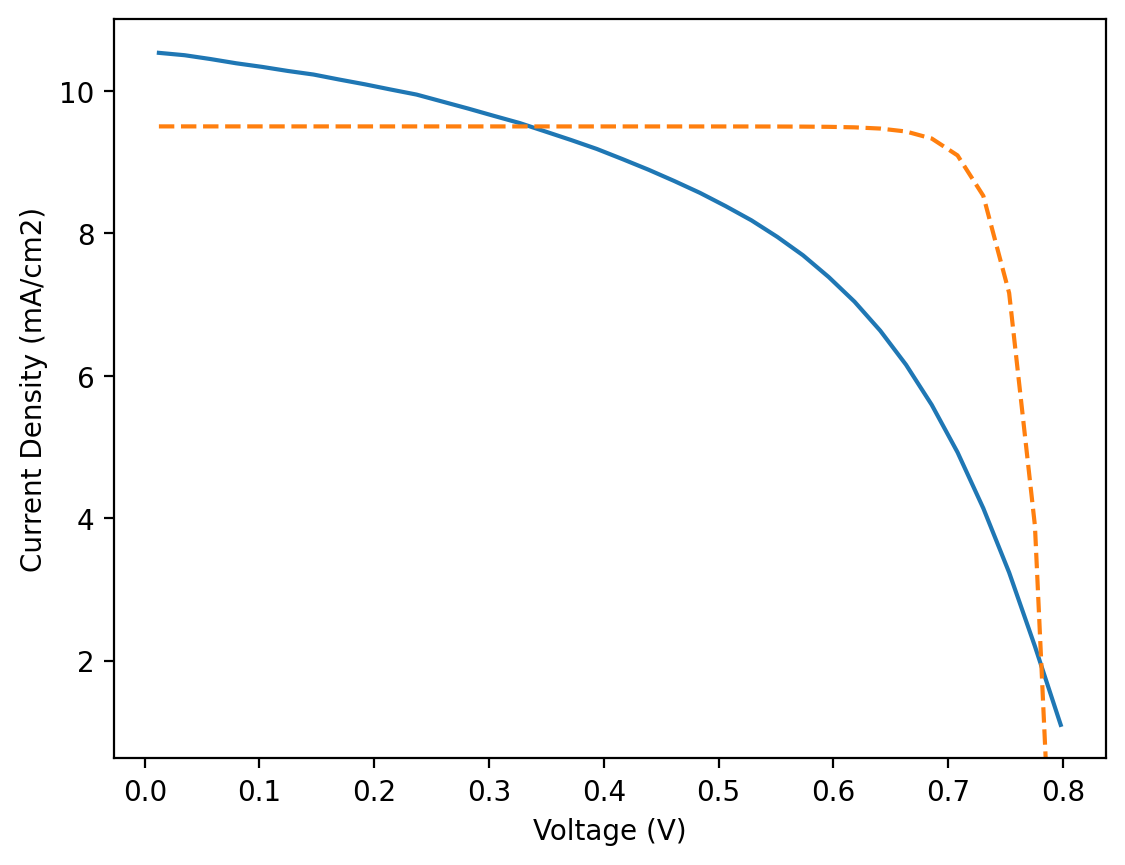

jo1:  4.350106824135765e-16
rs:  1.7327297378430757e-05
rsh:  648480.6674747295
jl:  0.009503019703930382
voc:  798.0640999999999
jsc:  10.536022857142857
vmpp:  573.5706
pce:  4.412007478521428
ff:  52.47129234114474


In [31]:
n = 2
fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area, plot=True)
print('jo1: ', fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area, plot=False)['jo1'])
print('rs: ', fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area, plot=False)['rs'])
print('rsh: ', fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area, plot=False)['rsh'])
print('jl: ', fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area, plot=False)['jl'])
print('voc: ', 1000*fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area, plot=False)['voc'])
print('jsc: ', 1000*fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area, plot=False)['jsc'])
print('vmpp: ', 1000*fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area, plot=False)['vmpp'])
print('pce: ', 100*fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area, plot=False)['pce'])
print('ff: ', 100*fit_light(df['voltage_measured'][n], df['current_measured_flipped'][n], area, plot=False)['ff'])

In [27]:
name_key = {
    'A': '9% Excess PbI2',
    'B': '12% Excess PbI2',
    'C': '15% Excess PbI2',
    'FTO': 'FTO',
    'ITO': 'ITO',
    'AZ': '9% Excess PbI2',
    'BZ': '15% Excess PbI2',
    'CZ': '12% Excess PbI2',

    'TIO2': 'TiO2',
    'REV': 'Reverse',
    'FWD': 'Forward',
    'rev': 'Reverse',
    'fwd': 'Forward'
    

}

def getname(n): #ETL
    letter = n.split('_')[0]
    return name_key[letter]

def getname_1(n): #HTL
    letter_2 = n.split('_')[1]
    return name_key[letter_2]

def getname_3(n): #HTL
    letter_3 = n.split('_')[5]
    return name_key[letter_3]

df['Excess_PbI2'] = ''
df['TCO'] = ''
df['dir'] = ''
# df['condition'] = ''



# for n in range(df.shape[0]):
#     df['dspacing'][n] = theta_to_d(df['angles'][n]
    
df['TCO'] = df['name'].apply(getname)
df['Excess_PbI2'] = df['name'].apply(getname_1)
df['dir'] = df['name'].apply(getname_3)

In [28]:
# Filtering out bugged curves (manual entry)
# df = df[df.name != 'CsPbSnF3_25_5isl']

# plotting a subset of experiment

Filter_1 = ''
Filter_2 = 'round1'
Filter_3 = ''

df_filter1 = df[df.name.str.contains(Filter_1)]
df_filter2 = df_filter1[df_filter1.name.str.contains(Filter_2)]
df_filter3 = df_filter2[df_filter2.name.str.contains(Filter_3)]
df_filter3.reset_index(drop=True, inplace=True)

# list scans in your filtered dataset before plotting
count = 0
for n in df_filter3['name'].unique(): 
    print(n)
    count +=1
print(count)

ITO_C_round1_sample1_pixel1_rev_light
ITO_C_round1_sample1_pixel2_rev_light
ITO_C_round1_sample1_pixel1_fwd_light
ITO_BZ_round1_sample1_pixel1_rev_light
ITO_C_round1_sample1_pixel2_fwd_light
ITO_C_round1_sample1_pixel3_rev_light
ITO_C_round1_sample1_pixel3_fwd_light
ITO_CZ_round1_sample1_pixel1_rev_light
ITO_CZ_round1_sample1_pixel1_fwd_light
ITO_BZ_round1_sample1_pixel2_rev_light
ITO_BZ_round1_sample1_pixel1_fwd_light
ITO_AZ_round1_sample1_pixel3_rev_light
FTO_B_round1_sample2_pixel2_rev_light
ITO_BZ_round1_sample1_pixel2_fwd_light
ITO_AZ_round1_sample1_pixel3_fwd_light
FTO_B_round1_sample2_pixel2_fwd_light
FTO_B_round1_sample2_pixel1_rev_light
ITO_AZ_round1_sample1_pixel2_rev_light
FTO_A_round1_sample1_pixel1_rev_light
FTO_C_round1_sample2_pixel1_rev_light
FTO_C_round1_sample2_pixel1_fwd_light
ITO_B_round1_sample1_pixel3_rev_light
FTO_B_round1_sample2_pixel1_fwd_light
ITO_AZ_round1_sample1_pixel2_fwd_light
ITO_B_round1_sample1_pixel1_rev_light
FTO_C_round1_sample2_pixel3_rev_light
FT

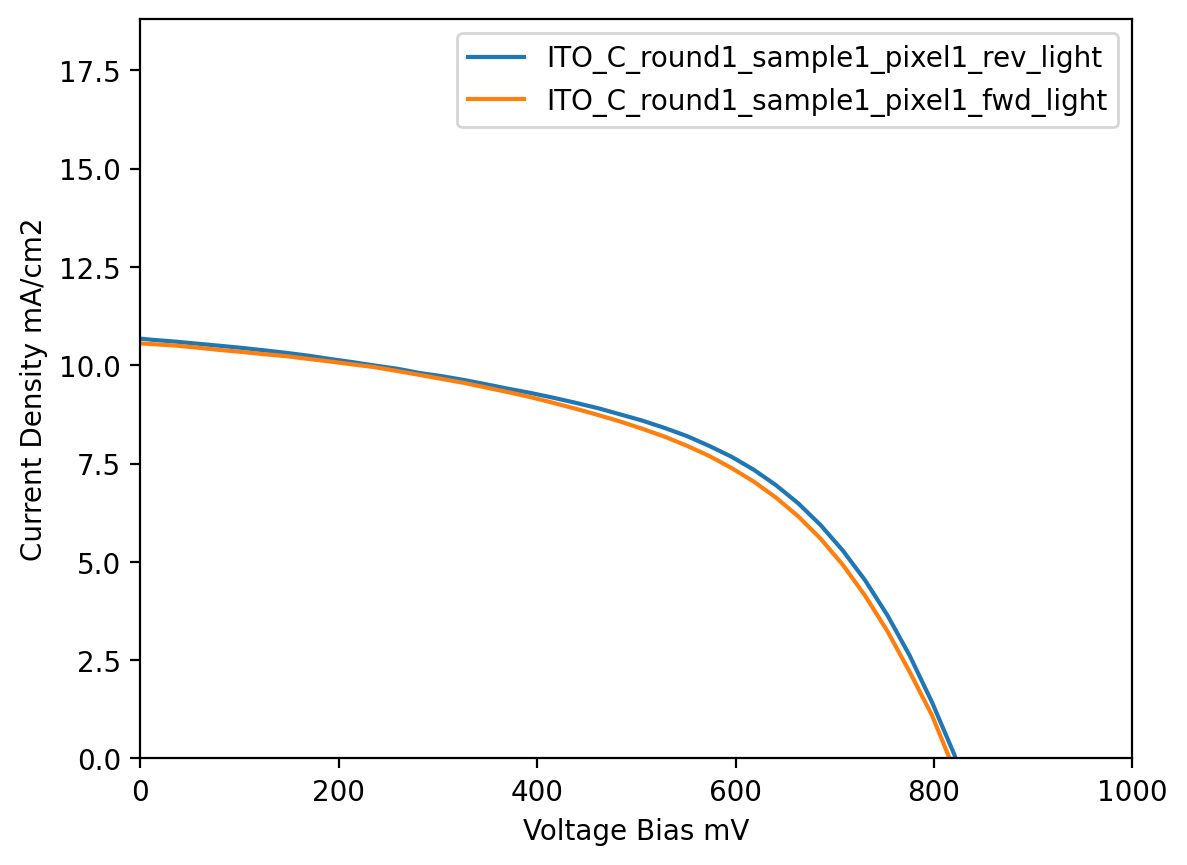

In [29]:
curve1=0
curve2=2
# for q in range(0,10):
plt.plot(df_filter3['voltage_measured'][curve1]*1000, df_filter3['current_measured_flipped'][curve1]/.07/.001, label=(df_filter3['name'][curve1]))
plt.plot(df_filter3['voltage_measured'][curve2]*1000, df_filter3['current_measured_flipped'][curve2]/.07/.001, label=(df_filter3['name'][curve2]))



# plt.xlim(0, 800)
# plt.ylim(0, 18.8)
plt.ylabel('Current Density mA/cm2')
# plt.ylabel('Log Current density mA/cm2 ')

plt.xlabel('Voltage Bias mV')
plt.legend()
# plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1), shadow=True, ncol=1)

# plt.plot([0,0], [0,25], color = 'black',linestyle='--')
# plt.plot([1200,0], [0,0], color = 'black',linestyle='--')


plt.xlim(0, 1000)
plt.ylim(0, 18.8)
# plt.title(df['dir'][0])
# plt.title('Champion Device')

# plt.legend()
plt.show()

In [30]:
# Filtering out bugged curves (manual entry)
# df = df[df.name != 'CsPbSnF3_25_5isl']

# plotting a subset of experiment

Filter_1 = 'FTO'
Filter_2 = 'C'
Filter_3 = ''

df_filter1 = df[df.name.str.contains(Filter_1)]
df_filter2 = df_filter1[df_filter1.name.str.contains(Filter_2)]
df_filter3 = df_filter2[df_filter2.name.str.contains(Filter_3)]
df_filter3.reset_index(drop=True, inplace=True)

# list scans in your filtered dataset before plotting
count = 0
for n in df_filter3['name'].unique(): 
    print(n)
    count +=1
print(count)

FTO_C_round1_sample2_pixel1_rev_light
FTO_C_round1_sample2_pixel1_fwd_light
FTO_C_round1_sample2_pixel3_rev_light
FTO_C_round1_sample2_pixel3_fwd_light
FTO_C_round1_sample1_pixel3_rev_light
FTO_C_round1_sample2_pixel2_fwd_light
FTO_C_round1_sample1_pixel2_rev_light
FTO_C_round1_sample2_pixel2_rev_light
FTO_C_round1_sample1_pixel3_fwd_light
FTO_C_round1_sample1_pixel2_fwd_light
FTO_C_round2_sample2_pixel1_rev_light
FTO_C_round2_sample2_pixel1_fwd_light
FTO_C_round2_sample1_pixel3_rev_light
FTO_C_round2_sample2_pixel2_rev_light
FTO_C_round2_sample2_pixel2_fwd_light
FTO_C_round2_sample1_pixel3_fwd_light
FTO_C_round2_sample1_pixel2_rev_light
FTO_C_round2_sample1_pixel2_fwd_light
FTO_C_round1_sample1_pixel1_rev_light
FTO_C_round1_sample1_pixel1_fwd_light
FTO_C_round2_sample1_pixel1_fwd_light
FTO_C_round2_sample1_pixel1_rev_light
FTO_C_round2_sample2_pixel3_rev_light
23


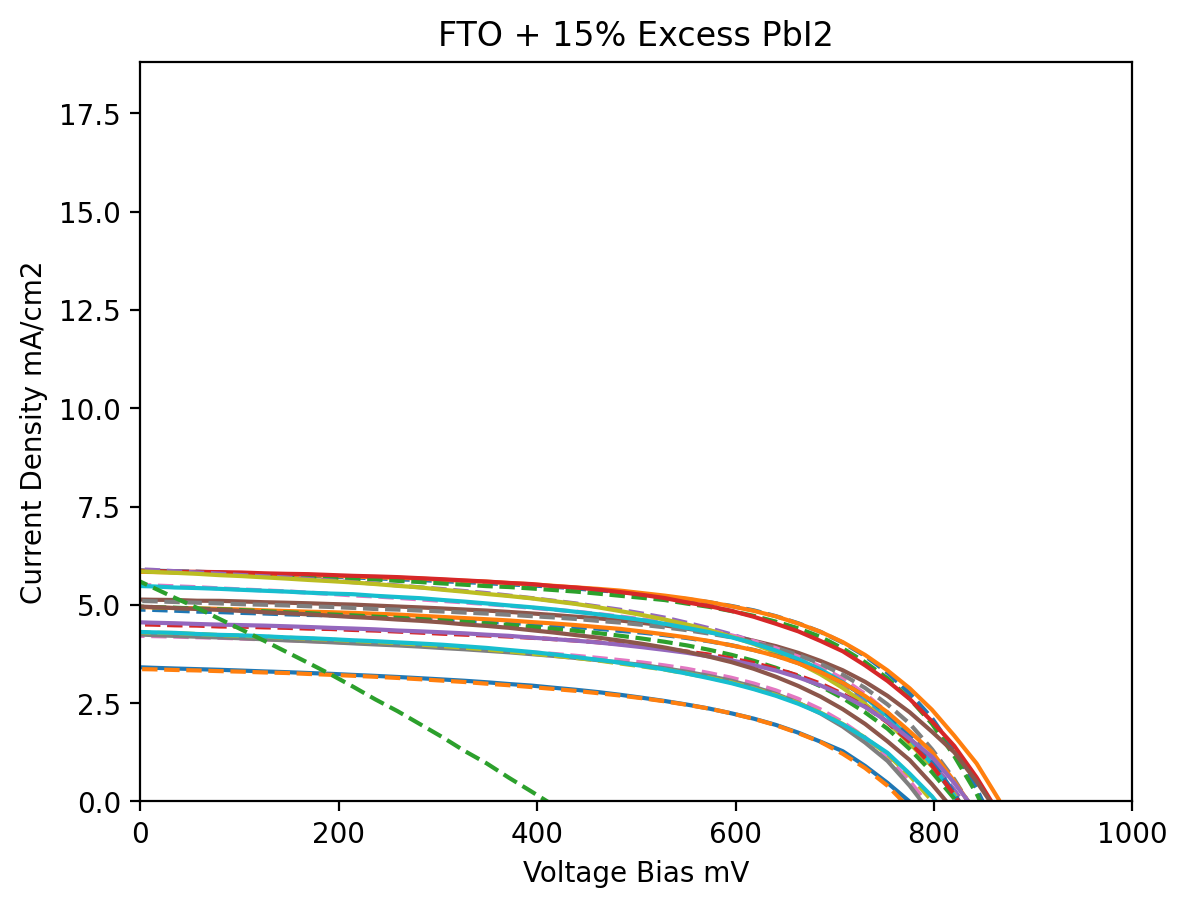

In [16]:
colors = plt.cm.viridis(np.linspace(0,1,df_filter3.shape[0]))
q = 0
for q in range(0,df_filter3.shape[0]):
    
    if df_filter3['dir'][q] == 'Reverse':
        linestyle_selection = '--'
    if df_filter3['dir'][q] == 'Forward':
        linestyle_selection = '-'  
        
    plt.plot(df_filter3['voltage_measured'][q]*1000, df_filter3['current_measured_flipped'][q]/.07/.001, label=df_filter3['name'][q], linestyle=linestyle_selection)#color=colors[q])


plt.xlim(0, 1000)
plt.ylim(0, 18.8)
plt.ylabel('Current Density mA/cm2')
# plt.ylabel('Log Current density mA/cm2 ')

plt.xlabel('Voltage Bias mV')
# plt.legend()
# plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1), shadow=True, ncol=1)

# plt.plot([0,0], [0,25], color = 'black',linestyle='--')
# plt.plot([1200,0], [0,0], color = 'black',linestyle='--')
plt.title('FTO + 15% Excess PbI2')
# plt.title(df_filter3['dir'][0])
# plt.legend(['dotted = fwd', 'f'])
plt.show()

In [19]:
# Filtering out bugged curves (manual entry)
# df = df[df.name != 'CsPbSnF3_25_5isl']

# plotting a subset of experiment

Filter_1 = 'round1'
Filter_2 = 'rev'
Filter_3 = ''

df_filter1 = df[df.name.str.contains(Filter_1)]
df_filter2 = df_filter1[df_filter1.name.str.contains(Filter_2)]
df_filter3 = df_filter2[df_filter2.name.str.contains(Filter_3)]
df_filter3.reset_index(drop=True, inplace=True)

# list scans in your filtered dataset before plotting
count = 0
for n in df_filter3['name'].unique(): 
    print(n)
    count +=1
print(count)

ITO_C_round1_sample1_pixel1_rev_light
ITO_C_round1_sample1_pixel2_rev_light
ITO_BZ_round1_sample1_pixel1_rev_light
ITO_C_round1_sample1_pixel3_rev_light
ITO_CZ_round1_sample1_pixel1_rev_light
ITO_BZ_round1_sample1_pixel2_rev_light
ITO_AZ_round1_sample1_pixel3_rev_light
FTO_B_round1_sample2_pixel2_rev_light
FTO_B_round1_sample2_pixel1_rev_light
ITO_AZ_round1_sample1_pixel2_rev_light
FTO_A_round1_sample1_pixel1_rev_light
FTO_C_round1_sample2_pixel1_rev_light
ITO_B_round1_sample1_pixel3_rev_light
ITO_B_round1_sample1_pixel1_rev_light
FTO_C_round1_sample2_pixel3_rev_light
FTO_B_round1_sample2_pixel3_rev_light
ITO_BZ_round1_sample1_pixel3_rev_light
FTO_C_round1_sample1_pixel3_rev_light
FTO_C_round1_sample1_pixel2_rev_light
FTO_C_round1_sample2_pixel2_rev_light
FTO_B_round1_sample1_pixel3_rev_light
ITO_A_round1_sample1_pixel3_rev_light
FTO_A_round1_sample2_pixel3_rev_light
ITO_A_round1_sample1_pixel2_rev_light
FTO_C_round1_sample1_pixel1_rev_light
FTO_B_round1_sample1_pixel2_rev_light
FTO_A_

In [20]:
df_filter3 = df_filter3.sort_values(by=['Excess_PbI2'],  ascending=False)
df_filter3 = df_filter3.reset_index()

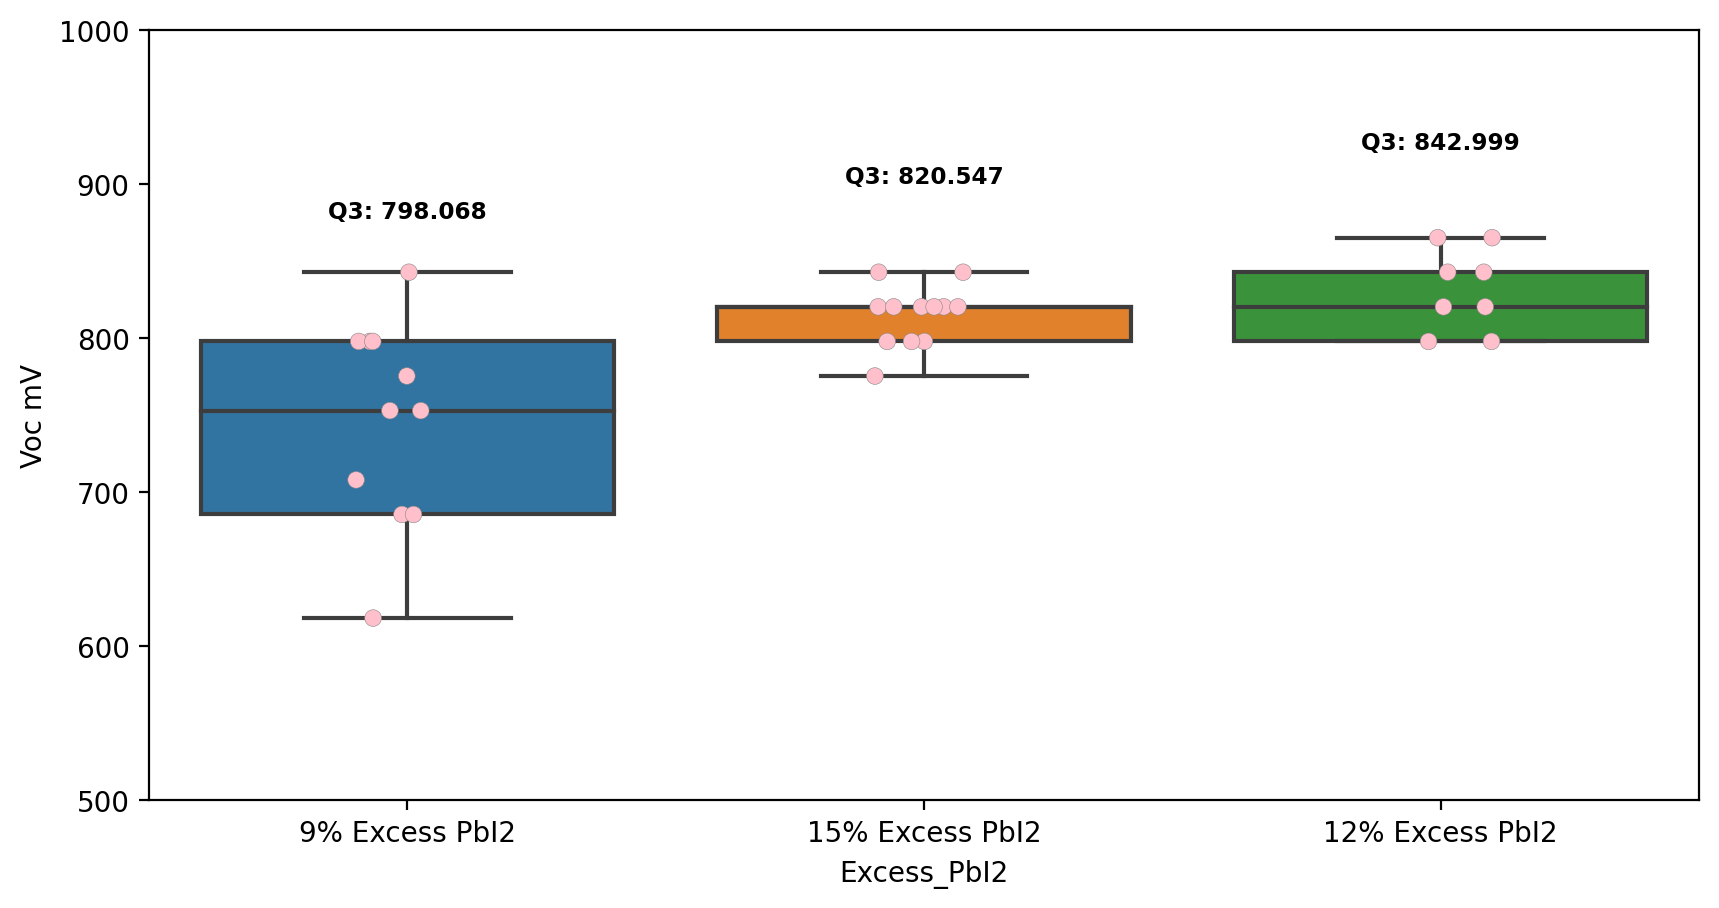

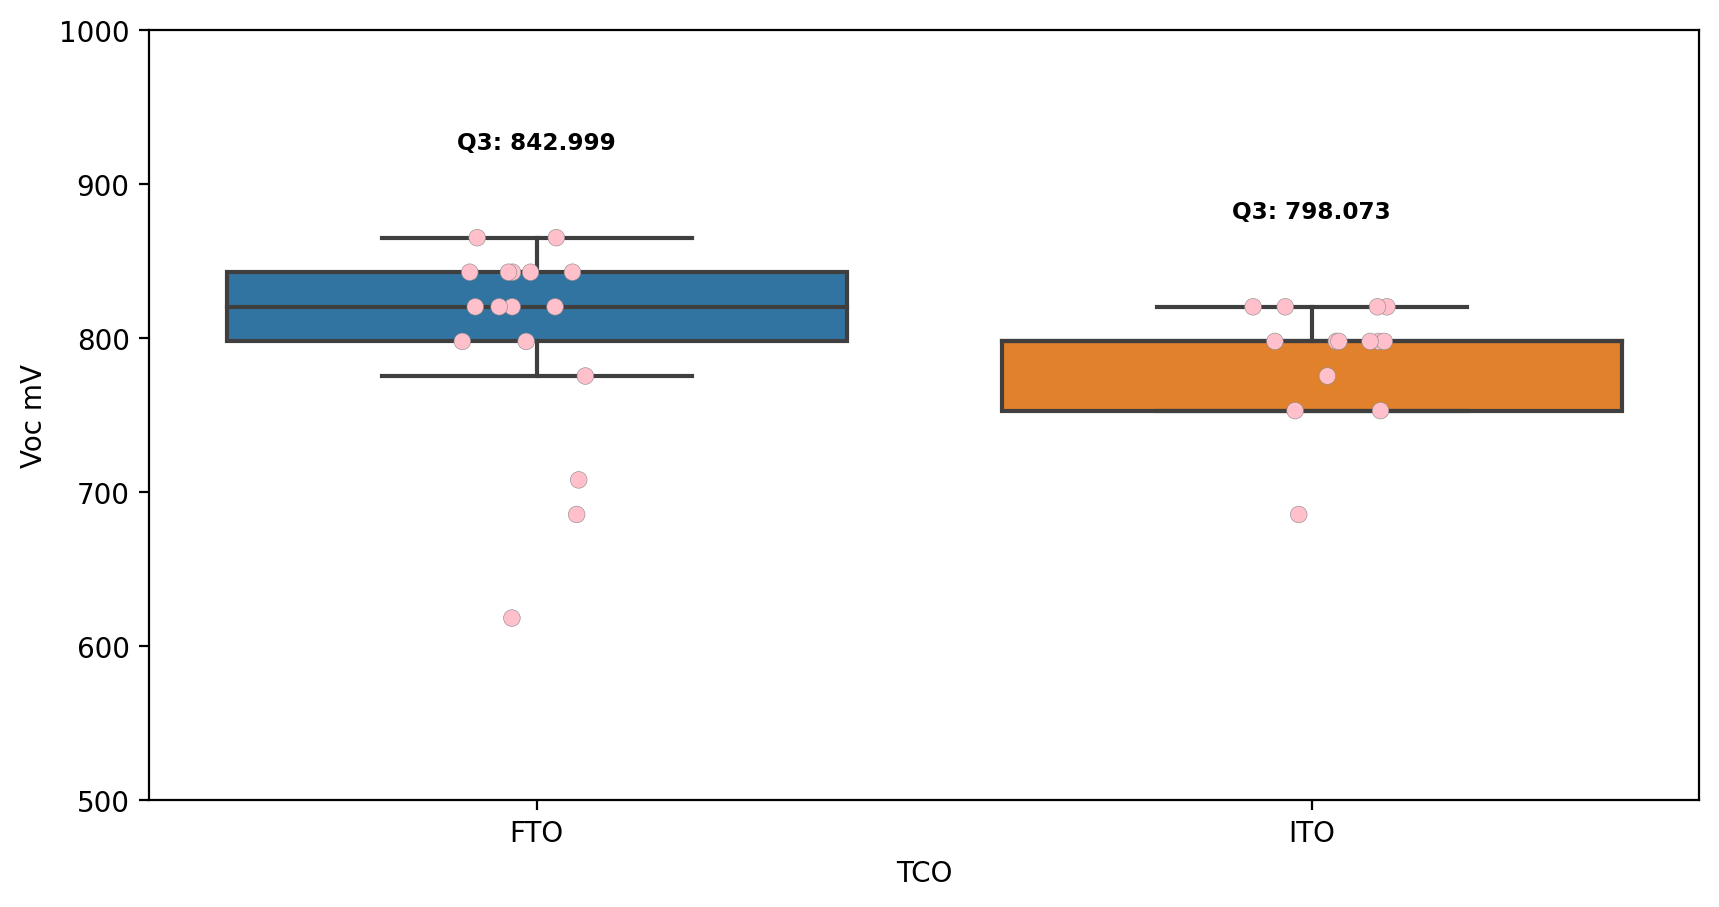

In [21]:
data = df_filter3

xvar1 = 'Excess_PbI2'
xvar2 = 'TCO'
yvar = 'voc'



if yvar == 'jsc':
    y_axis_label = 'Jsc mA/cm2'
if yvar == 'voc':
    y_axis_label = 'Voc mV'

if yvar == 'pce':
    y_axis_label = 'Power Conversion Effiency %'
    
if yvar == 'ff':
    y_axis_label = 'Fill Factor %'
    

    
pce_lim = 5
voc_lim = 1000
jsc_lim = 12

import seaborn as sns
plt.figure(figsize=[10,5])
ax0 = sns.boxplot(x=xvar1, y=yvar, data=data, showfliers=False)

if yvar == 'pce':
    ax0.set(ylim=(0, pce_lim))
    
if yvar == 'voc':
    ax0.set(ylim=(500, voc_lim))
    
if yvar == 'jsc':
    ax0.set(ylim=(0, jsc_lim))


sns.stripplot(x=xvar1, y=yvar, data=data,
              size=6, color="pink", linewidth=0.2)

medians = data.groupby([xvar1])[yvar].describe()['75%'][::-1]
vertical_offset = data[yvar].median() * 0.1 # offset from median for display

for xtick in ax0.get_xticks():
    ax0.text(xtick,medians[xtick] + vertical_offset,'Q3: '+str(np.round(medians[xtick],3)), 
            horizontalalignment='center',size='small',color='k',weight='bold')

ax0.set_ylabel(y_axis_label)
plt.show()

plt.figure(figsize=[10,5])
ax1 = sns.boxplot(x=xvar2, y=yvar, data=data, showfliers=False)


if yvar == 'pce':
    ax1.set(ylim=(0, pce_lim))
    
if yvar == 'voc':
    ax1.set(ylim=(500, voc_lim))
    
if yvar == 'jsc':
    ax1.set(ylim=(0, jsc_lim))

    
medians = []
medians = data.groupby([xvar2])[yvar].describe()['75%']
vertical_offset = data[yvar].median() * 0.1 # offset from median for display

xtick = 0
for xtick in ax1.get_xticks():
    ax1.text(xtick,medians[xtick] + vertical_offset,'Q3: '+str(np.round(medians[xtick],3)),
            horizontalalignment='center',size='small',color='k',weight='bold')




sns.stripplot(x=xvar2, y=yvar, data=data,
              size=6, color="pink", linewidth=0.2)
ax1.set_ylabel(y_axis_label)
plt.show()